## Домашнее задание

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

## Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score


In [2]:
df = pd.read_pickle('../Lesson_01/lesson_01_preprocessing.pkl')
df.head()

,id,label,tweet,clear_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,user when father is dysfunctional and is so se...,"[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[user, father, dysfunct, selfish, drag, kid, d...","[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit can use cause...,"[user, user, thanks, for, lyft, credit, can, u...","[user, user, thanks, lyft, credit, use, cause,...","[user, user, thank, lyft, credit, use, caus, o...","[user, user, thank, lyft, credit, use, caus, o..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesti]"
3,4,0.0,#model i love u take with u all the time in ...,model love take with all the time in ur,"[model, love, take, with, all, the, time, in, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]"
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguid, societi, motiv]"


Проверим на пропуски столбец ``'label'`` и отсутствующие заполним ``0`` (на этой итерации)


Затем построим классификатор и на его основании предскажем метки твитов с пропущенными метками

In [3]:
df['label'].unique()

array([ 0.,  1., nan])

In [4]:
df['label'].value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

In [5]:
df['label'].fillna(0, inplace=True)

In [6]:
df['label'].astype(int).value_counts()

0    46917
1     2242
Name: label, dtype: int64

### Выделим метки и разделим на train и test

In [7]:
X, y = df['tweet_stemmed'], df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train = [" ".join(x) for x in X_train]
X_test = [" ".join(x) for x in X_test]

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [8]:
compare_freq = pd.DataFrame(columns=['Token_frequency', 'f1_score'])

In [9]:
# Обучим на всех токенах
vec = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=1,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

compare_freq.loc[compare_freq.shape[0]] = ['All tokens', f1_score(y_true=y_test, y_pred=pred)]

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     15793
         1.0       0.33      0.58      0.42       430

    accuracy                           0.96     16223
   macro avg       0.66      0.77      0.70     16223
weighted avg       0.97      0.96      0.96     16223



In [10]:
# Обучим на токенах с низкой частотой (максимум в 30% документов)
vec = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.3, 
                      min_df=1,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[compare_freq.shape[0]] = ['Low frequency tokens', f1_score(y_true=y_test, y_pred=pred)]

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     15783
         1.0       0.34      0.59      0.43       440

    accuracy                           0.96     16223
   macro avg       0.66      0.78      0.70     16223
weighted avg       0.97      0.96      0.96     16223



In [11]:
# Обучим на токенах с высокой частотой (минимум в 100 документах)
vec = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=100,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[compare_freq.shape[0]] = ['High frequency tokens', f1_score(y_true=y_test, y_pred=pred)]

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16043
         1.0       0.12      0.52      0.20       180

    accuracy                           0.95     16223
   macro avg       0.56      0.74      0.59     16223
weighted avg       0.98      0.95      0.97     16223



In [12]:
# Обучим на токенах средней частоты
vec = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.7, 
                      min_df=100,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[compare_freq.shape[0]] = ['Middle frequency tokens', f1_score(y_true=y_test, y_pred=pred)]

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16043
         1.0       0.12      0.52      0.20       180

    accuracy                           0.95     16223
   macro avg       0.56      0.74      0.59     16223
weighted avg       0.98      0.95      0.97     16223



In [13]:
compare_freq['TFIDF_f1_score'] = 0

In [14]:
# Обучим на токенах средней частоты
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.7, 
                      min_df=100,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[3, 'TFIDF_f1_score'] = f1_score(y_true=y_test, y_pred=pred)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16048
         1.0       0.12      0.54      0.20       175

    accuracy                           0.95     16223
   macro avg       0.56      0.75      0.59     16223
weighted avg       0.99      0.95      0.97     16223



In [15]:
# Обучим на всех токенах
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=1)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[0, 'TFIDF_f1_score'] = f1_score(y_true=y_test, y_pred=pred)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16027
         1.0       0.16      0.60      0.25       196

    accuracy                           0.96     16223
   macro avg       0.58      0.78      0.61     16223
weighted avg       0.98      0.96      0.97     16223



In [16]:
# Обучим на токенах низкой частоты
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.3, 
                      min_df=1,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[1, 'TFIDF_f1_score'] = f1_score(y_true=y_test, y_pred=pred)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16027
         1.0       0.15      0.60      0.25       196

    accuracy                           0.96     16223
   macro avg       0.57      0.78      0.61     16223
weighted avg       0.98      0.96      0.97     16223



In [17]:
# Обучим на токенах высокой частоты
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=100)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))
compare_freq.loc[2, 'TFIDF_f1_score'] = f1_score(y_true=y_test, y_pred=pred)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     16048
         1.0       0.12      0.54      0.20       175

    accuracy                           0.95     16223
   macro avg       0.56      0.75      0.59     16223
weighted avg       0.99      0.95      0.97     16223



In [18]:
compare_freq

,Token_frequency,f1_score,TFIDF_f1_score
0,All tokens,0.420521,0.247120
1,Low frequency tokens,0.430359,0.245026
2,High frequency tokens,0.198083,0.201285
3,Middle frequency tokens,0.198083,0.201285


In [19]:
compare_freq.loc[compare_freq['f1_score']==compare_freq['f1_score'].max(), 
                 'Token_frequency'].values[0]

'Low frequency tokens'

__Задание 1 - наиболее выжными оказались токены встречающиеся редко - для них наибольшее значение f1 score по классу 1, и примерно постоянное значение по классу 0.__

TFIDF учитывает частоту вхождения поэтому здесь лучше для всех токенов

## Задание 2. 
Получить наиболее значимые фичи

In [20]:
vec = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.3, 
                      min_df=1,)
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     15783
         1.0       0.34      0.59      0.43       440

    accuracy                           0.96     16223
   macro avg       0.66      0.78      0.70     16223
weighted avg       0.97      0.96      0.96     16223



In [21]:
ft = pd.DataFrame({'tokens': vec.get_feature_names(), 'coef': clf.coef_[0]})
ft.sort_values(by='coef').head(10)


,tokens,coef
2799,bihday,-2.042485
20496,orlando,-1.959245
12164,healthi,-1.804823
28562,tomorrow,-1.554046
6630,day,-1.523865
11662,gun,-1.504463
21970,posit,-1.428776
25152,shoot,-1.415368
15925,life,-1.409495
30539,weekend,-1.375034


## Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

### Cравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

In [22]:
vectorizers = []

vec_TFIDF_all = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=1)
vectorizers.append(vec_TFIDF_all)

vec_TFIDF_high = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=100)
vectorizers.append(vec_TFIDF_high)

vec_TFIDF_middle = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.7, 
                      min_df=100)
vectorizers.append(vec_TFIDF_middle)

vec_TFIDF_low = TfidfVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.3, 
                      min_df=1)
vectorizers.append(vec_TFIDF_low)

vec_count_all = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=1)
vectorizers.append(vec_count_all)

vec_count_high = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=1.0, 
                      min_df=100)
vectorizers.append(vec_count_high)

vec_count_middle = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.7, 
                      min_df=100)
vectorizers.append(vec_count_middle)

vec_count_low = CountVectorizer(ngram_range=(1, 1), 
                      binary=False, 
                      max_df=0.3, 
                      min_df=1)
vectorizers.append(vec_count_low)

vec_hash = HashingVectorizer(n_features=9900)
vectorizers.append(vec_hash)

compare = pd.DataFrame(columns=['Vectorizer', 'f1_score'])

for vec in tqdm(vectorizers):
    bow = vec.fit_transform(X_train)

    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)

    pred = clf.predict(vec.transform(X_test))
#     print(classification_report(pred, y_test))
    compare.loc[compare.shape[0]] = [str(vec), f1_score(y_true=y_test, y_pred=pred)]

compare

100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


,Vectorizer,f1_score
0,TfidfVectorizer(),0.247120
1,TfidfVectorizer(min_df=100),0.201285
2,"TfidfVectorizer(max_df=0.7, min_df=100)",0.201285
3,TfidfVectorizer(max_df=0.3),0.245026
4,CountVectorizer(),0.420521
5,CountVectorizer(min_df=100),0.198083
6,"CountVectorizer(max_df=0.7, min_df=100)",0.198083
7,CountVectorizer(max_df=0.3),0.430359
8,HashingVectorizer(n_features=9900),0.234542


In [23]:
compare.max()

Vectorizer    TfidfVectorizer(min_df=100)
f1_score                         0.430359
dtype: object

### Подобрать оптимальный размер для hashing векторайзера

In [24]:
# подбор для HashingVectorizer
vectorizers = []
compare = pd.DataFrame(columns=['Vectorizer', 'f1_score'])

for n in np.arange(100, 20000, 100):
    vec_hash = HashingVectorizer(n_features=n)
    vectorizers.append(vec_hash)

for vec in tqdm(vectorizers):
    bow = vec.fit_transform(X_train)

    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)

    pred = clf.predict(vec.transform(X_test))
#     print(classification_report(pred, y_test))
    compare.loc[compare.shape[0]] = [str(vec), f1_score(y_true=y_test, y_pred=pred)]

compare.max()

100%|██████████| 199/199 [02:14<00:00,  1.48it/s]


Vectorizer    HashingVectorizer(n_features=9900)
f1_score                                0.251055
dtype: object

### Убедиться что для сетки нет переобучения

#### Построим сетку

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
train_data = tf.data.Dataset.from_tensor_slices((pd.Series(X_train), y_train))
test_data = tf.data.Dataset.from_tensor_slices((pd.Series(X_test), y_test))

train_data = train_data.batch(16)
test_data = test_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

def custom_standartization(input_data):
    return input_data

Оценим seq_len на основании распределения длин твитов

In [27]:
df['tweet_stemmed'].map(lambda x: len(x)).value_counts()

9     5546
8     5486
10    5388
7     5077
11    4649
6     4247
5     4018
12    3246
4     3053
3     2672
13    2047
2     1113
14    1097
15     649
16     362
1      267
17     129
18      52
0       22
19      20
20      10
21       7
37       1
22       1
Name: tweet_stemmed, dtype: int64

In [28]:
vocab_size = 10000
# Исходя из распределения длин твитов (в словах) 
seq_len = 16

vectorize_layer = TextVectorization(
    standardize=custom_standartization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text only dataset (no labels) and call adapt to build the vocabulary
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [29]:
embedding_dim = 200
model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
#     GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [30]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [31]:
callback = EarlyStopping(monitor='val_loss', patience=5) # остановим обучение если на пяти эпохах нет улучшения метрики
history = model.fit(train_data, validation_data=test_data, epochs=25, callbacks=[callback])

Epoch 1/25
2059/2059 [==============================] - 67s 31ms/step - loss: 0.1360 - accuracy: 0.9553 - val_loss: 0.1210 - val_accuracy: 0.9570
Epoch 2/25
2059/2059 [==============================] - 78s 38ms/step - loss: 0.0809 - accuracy: 0.9678 - val_loss: 0.1617 - val_accuracy: 0.9571
Epoch 3/25
2059/2059 [==============================] - 79s 38ms/step - loss: 0.0584 - accuracy: 0.9776 - val_loss: 0.1637 - val_accuracy: 0.9551
Epoch 4/25
2059/2059 [==============================] - 77s 38ms/step - loss: 0.0471 - accuracy: 0.9821 - val_loss: 0.1862 - val_accuracy: 0.9520
Epoch 5/25
2059/2059 [==============================] - 59s 28ms/step - loss: 0.0428 - accuracy: 0.9846 - val_loss: 0.2296 - val_accuracy: 0.9559
Epoch 6/25
2059/2059 [==============================] - 57s 27ms/step - loss: 0.0466 - accuracy: 0.9826 - val_loss: 0.2000 - val_accuracy: 0.9521


In [32]:
pred = model.predict(X_test)

pr = pd.Series(list(pred)).map(lambda x: 1 if x > 0.5 else 0)

f1_score(y_true=y_test, y_pred=pr)

0.429096252755327

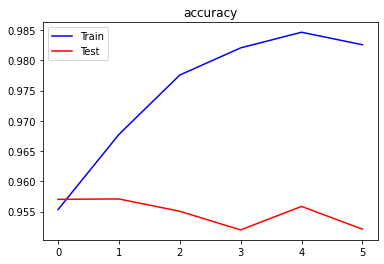

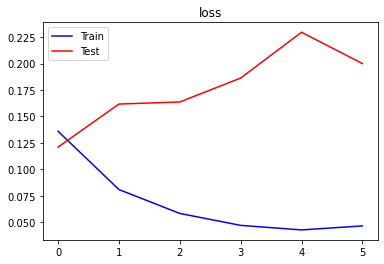

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Результаты сети лучше чем логистической регрессии